## Download testing data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import driveanon

In [3]:
# %%capture
# driveanon.save('13agtkTBW9HydkjwnquIt6axiDvbg1D9p', filename='data.tar.gz')
# ! tar -xzvf data.tar.gz
# ! rm data.tar.gz

## Plot difference maps

In [4]:
import os
from pathlib import Path
import glacierpoly as gpoly
import glob
import geopandas as gpd
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.io import imshow
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
from skimage.measure import label, regionprops, regionprops_table
from rasterstats import zonal_stats
from rasterio.plot import show
from rasterio import mask

import warnings
warnings.filterwarnings('ignore')

In [5]:
diffs = sorted(glob.glob('data/diff*.tif'))
gdf = gpd.read_file('data/south_cascade_rgi_polygon.geojson')

In [6]:
len(diffs)

17

In [7]:
'''
skip erode islands for 
'data/diff_dem_ref_1970-09-29.tif'
'data/diff_dem_ref_1979-10-06.tif'


'data/diff_dem_ref_1974-08-10.tif' is bad and has too much noise for this too work

the rest work with defaults
''';

In [8]:
dod = diffs[6]
dod

'data/diff_dem_ref_1986-09-23.tif'

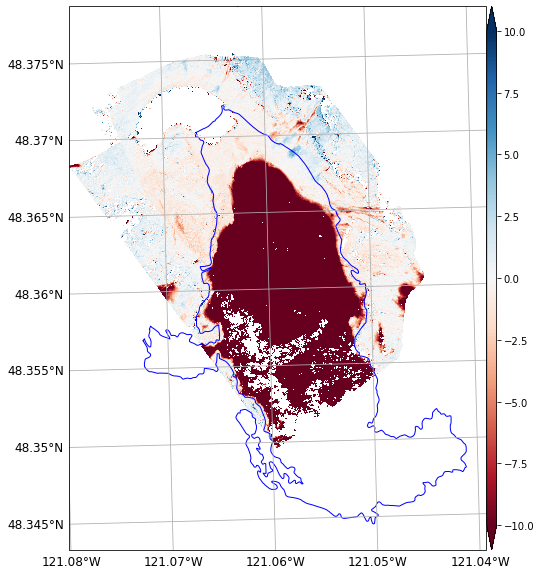

In [9]:
gpoly.plotting.plot_tif(dod, 
                        glacier_outline_gdf=gdf, 
                        vmin=-10,vmax=10,
                        cmap='RdBu')

## Detect edges

In [10]:
def multi_dil(im, num, window):
    for i in range(num):
        im = dilation(im, window)
    return im
def multi_ero(im, num, window):
    for i in range(num):
        im = erosion(im, window)
    return im

def replace_and_fill_nodata_value(array, nodata_value, fill_value):
    if np.isnan(nodata_value):
        masked_array = np.nan_to_num(array, nan=fill_value)
    else:
        mask = array == nodata_value
        masked_array = np.ma.masked_array(array, mask=mask)
        masked_array = np.ma.filled(masked_array, fill_value=fill_value)

    return masked_array

## clip raster with 1 km buffer around input glacier polygon
- handles DoD mosaics capturing multiple glaciers
- idea is to run this iteratively over RGI polygon to get new polygon for each glacier

In [11]:
buffer = gdf.buffer(1000)

source = rasterio.open(dod,masked=True)
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
masked_array, transform = rasterio.mask.mask(source, buffer)
array = masked_array.squeeze()
array = replace_and_fill_nodata_value(array, source.nodata, 0)

## might be useful
# array = cv2.bilateralFilter(array,21,75,75)
# array = cv2.GaussianBlur(array, (21,21), 10)

## might be desired
# mask = array > -2
# array = np.ma.masked_array(array, mask=mask)
# array = np.ma.filled(array, fill_value=0)

array = np.uint8(array)

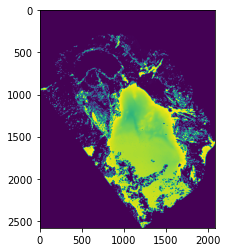

In [12]:
plt.imshow(array)

## erode islands
- this step is overkill for two of the examples, but necessary for the rest

In [13]:
window = np.ones((9,9)).astype(int)
array = opening(array, window)

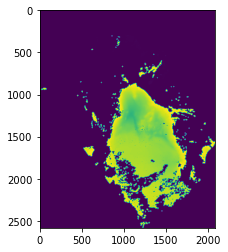

In [14]:
plt.imshow(array)

## detect edges

In [15]:
canny = cv2.Canny(array,50,150)

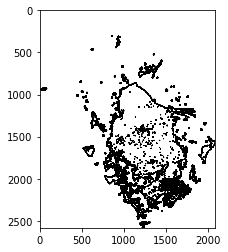

In [16]:
plt.imshow(canny,cmap='Greys',vmax=1);

## dilate edges
- can modify this window size to enhance connectedness

In [17]:
window = np.ones((3,3)).astype(int)
multi_dilated = multi_dil(canny, 4,window)

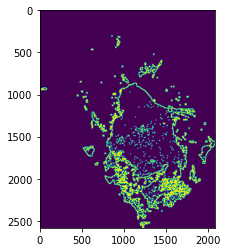

In [18]:
plt.imshow(multi_dilated)

## close areas
- 1E6 as per trial and error

In [19]:
area_closed = area_closing(multi_dilated, 1E6)

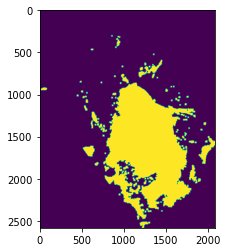

In [20]:
plt.imshow(area_closed)

## label areas

In [21]:
label_im = label(area_closed)
regions = regionprops(label_im)

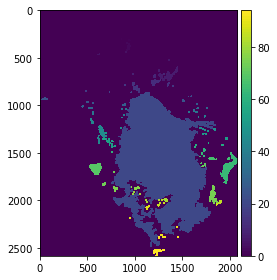

In [22]:
imshow(label_im,cmap=plt.cm.get_cmap('viridis', len(regions)))

## get stats
- other blobs with large area may be of interest
- right now only extracting largest DoD blob (the glacier)

In [23]:
properties = ['area','convex_area','bbox_area', 'extent',  
              'mean_intensity', 'solidity', 'eccentricity', 
              'orientation']
df = pd.DataFrame(regionprops_table(label_im, array, 
             properties=properties))

In [24]:
df.sort_values(by=['area'], ascending=False).head()

,area,convex_area,bbox_area,extent,mean_intensity,solidity,eccentricity,orientation
19,986421,1351159,1773408,0.556229,197.154177,0.730055,0.779831,0.208681
62,22745,35496,64020,0.355280,185.651396,0.640776,0.938950,-0.458405
68,12010,13012,18200,0.659890,194.555953,0.922994,0.476869,0.885659
6,11820,19543,33760,0.350118,154.141371,0.604820,0.908047,-1.103082
73,10309,13225,18612,0.553890,157.553788,0.779509,0.911265,0.034249


## get largest region

In [25]:
max_area_index = df[df['area'] == df['area'].max()].index[0]
if max_area_index == 0:
    pass
else:
    max_area_index = max_area_index + 1

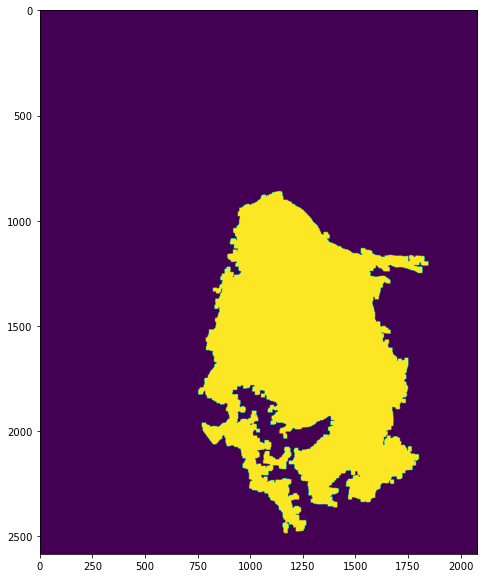

In [26]:
mask = label_im != max_area_index
masked_array = np.ma.masked_array(label_im, mask=mask)
masked_array = np.ma.filled(masked_array, fill_value=1)
masked_array = masked_array.astype(np.uint8)
fig,ax=plt.subplots(figsize=(10,10))
ax.imshow(masked_array)

## write to geotiff

In [27]:
! rm tmp.tif
! rm -rf tmp.geojson

In [28]:
with rasterio.open(
    'tmp.tif',
    'w',
    driver='GTiff',
    height=masked_array.shape[0],
    width=masked_array.shape[1],
    count=1,
    nodata=1,
    dtype=masked_array.dtype,
    crs=source.crs,
    transform=source.transform,
) as dst:
    dst.write(masked_array, 1)

In [29]:
# need inverse of what first polygonize operation gives... might be a better way to do this
! gdal_polygonize.py tmp.tif tmp.geojson
! gdal_rasterize -burn 1 -tr {source.res[0]} {source.res[0]} -a_nodata 0 -add tmp.geojson tmp.tif
! gdal_polygonize.py tmp.tif tmp.geojson

Several drivers matching geojson extension. Using GeoJSON
Creating output tmp.geojson of format GeoJSON.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Several drivers matching geojson extension. Using GeoJSON
0...10...20...30...40...50...60...70...80...90...100 - done.


In [30]:
diffs = sorted(glob.glob('data/diff*.tif'))
gdf = gpd.read_file('data/south_cascade_rgi_polygon.geojson')

In [31]:
gdf_new = gpd.read_file('tmp.geojson')
gdf_new = gdf_new[gdf_new.intersects(gdf.geometry[0])]
gdf_new = gdf_new[gdf_new.area == gdf_new.area.max()]

## clip areas outside boundary unless positive (glacier advanced)

In [32]:
diff = gpd.overlay(gdf_new, gdf, how='difference')
diff = diff.explode().reset_index().iloc[: , 2:]

diff_stats = zonal_stats(diff, dod)
mean_dods = []
for i in diff_stats:
    mean_dods.append(i['mean'])
    
diff['mean_dod'] = mean_dods

negative_elev_change_regions = diff[diff['mean_dod'] < 0]
gdf_new = gpd.overlay(gdf_new, negative_elev_change_regions, how='difference')

In [33]:
gdf_new.to_file('tmp.geojson')

'data/diff_dem_ref_1970-09-29.tif'

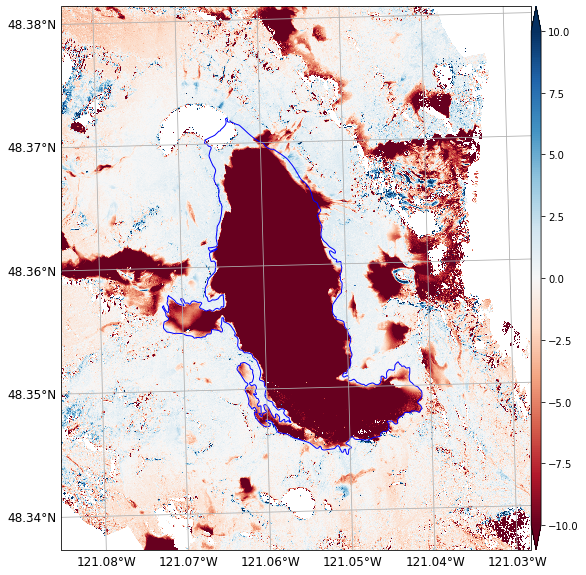

In [34]:
gpoly.plotting.plot_tif(diffs[0], 
                        glacier_outline_gdf=gdf, 
                        vmin=-10,vmax=10,
                        cmap='RdBu')
diffs[0]

'data/diff_dem_ref_1986-09-23.tif'

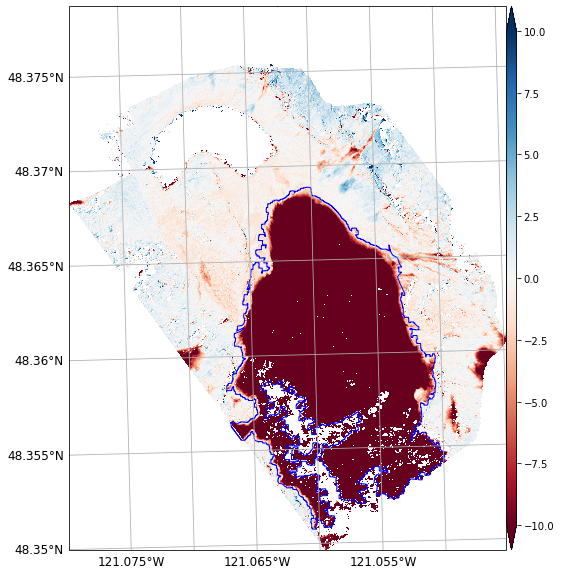

In [35]:
gpoly.plotting.plot_tif(dod, 
                        glacier_outline_gdf=gdf_new, 
                        vmin=-10,vmax=10,
                        cmap='RdBu')
dod

## merge with existing (ideally previous) glacier polygon

#### get max elevation in detected glacierized area

In [36]:
dem = 'data/reference_dem_2013-2015_WV_composite.tif'
max_caputed_elevation = zonal_stats('tmp.geojson', dem)[0]['max']

#### find areas in existing glacier polygon above max captured elevation

In [37]:
res_union = gpd.overlay(gdf, gdf_new, how='difference')
res_union = res_union.explode()
res_union = res_union.reset_index().iloc[: , 2:]
res_union = res_union[['geometry']]

In [38]:
stats = zonal_stats(res_union, dem)
max_elevations = []
for i in stats:
    max_elevations.append(i['max'])

In [39]:
res_union['max_elevations'] = max_elevations

#### merge where elevations are higher

In [40]:
remaining_area = res_union[res_union['max_elevations'] > max_caputed_elevation]

<AxesSubplot:>

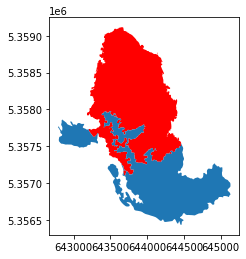

In [41]:
fig,ax = plt.subplots()
gdf_new.plot(ax=ax,color='r')
remaining_area.plot(ax=ax)

In [42]:
merged = gdf_new.geometry.append(remaining_area.geometry)
merged = gpd.GeoDataFrame(geometry=merged)

<AxesSubplot:>

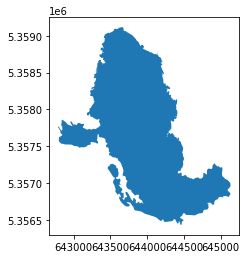

In [43]:
merged = merged.dissolve()
merged.plot()

In [44]:
p = str(Path(dod).parent.resolve())
n = str(Path(dod).stem)
out = os.path.join(p,'glacier_outline_'+ n.split('_')[-1] +'.geojson')

In [45]:
merged.to_file(out)